In [194]:
from database import *

def ticks_to_kbars(ticks, interval='5Min'):

    kbars = pd.DataFrame()
    
    kbars['open'] = ticks['close'].resample(interval).first()
    kbars['close'] = ticks['close'].resample(interval).last()
    kbars['high'] = ticks['close'].resample(interval).max()
    kbars['low'] = ticks['close'].resample(interval).min()
    kbars['volume'] = ticks['volume'].resample(interval).sum()
    
    kbars.dropna(inplace=True)
    
    return kbars

In [195]:
import talib

def get_technical_indicator(kbars):
    
#     kbars['rsi'] = talib.RSI(kbars.close, timeperiod=14)
    kbars['cci'] = talib.CCI(kbars.high, kbars.low, kbars.close, timeperiod=14)
    
    macd, macdsignal, macdhist = talib.MACD(kbars.close, fastperiod=5, slowperiod=34, signalperiod=5)
    
    kbars['macd'] = macd
    kbars['macdsignal'] = macdsignal
    kbars['macdhist'] = macdhist
    
    return kbars

In [256]:
def day_trading_backtest(code, date, connection, api):
    
    tw_calendar = get_calendar('XTAI')
    prev_trading_date = tw_calendar.previous_close(date).date()
    
    ticks = get_ticks(code, prev_trading_date, connection, api)[0].append(get_ticks(code, date, connection, api)[0])
    kbars = ticks_to_kbars(ticks)
    if kbars.empty:
        return pd.DataFrame()
    kbars = get_technical_indicator(kbars)
    prev_close_price = kbars['close'].get(pd.to_datetime(prev_trading_date).replace(hour=13, minute=30))
    kbars = kbars[date:]
            
    entry_price = 0
    entry_time = None
    
    exit_price = 0
    exit_time = None
    
    position = 0
    
            
    for ts in range(len(kbars)):
#         current_time = kbars.iloc[ts].name + pd.Timedelta(minutes=5)
        current_time = kbars.iloc[ts].name
        current_price = kbars['open'][ts]
        if(ts == 0 and prev_close_price is not None and current_price >= prev_close_price * 1.04):
            break
        elif ts < 2:
            continue
        
        if (
            current_time <= date.replace(hour=9, minute=30, second=0) and
            kbars['close'][0] < kbars['close'][1] and
            kbars.iloc[ts-2]['macdhist'] > 0 and
            kbars.iloc[ts-1]['cci'] < 50 and
            kbars.iloc[ts-2]['cci'] > 0 and
            kbars.iloc[ts-1]['cci'] > kbars.iloc[ts-2]['cci'] and
            kbars.iloc[ts-1]['macdhist'] > 0 and
            kbars['close'][ts-2] > kbars['close'][ts-1] and
            position == 0
        ):
            
            position = 2          
            entry_price = current_price
            entry_time = current_time.time()

            print('[{}] buy {} at {}'.format(current_time, code, current_price))
        
        elif (
            (current_price <= entry_price * 0.98 and position != 0) or
            (
            kbars.iloc[ts-2]['macdhist'] > 0 and
            kbars.iloc[ts-2]['cci'] > 100 and
            kbars.iloc[ts-1]['cci'] > kbars.iloc[ts-2]['cci'] and
            kbars.iloc[ts-1]['macdhist'] > 0 and
            kbars['close'][ts-2] < kbars['close'][ts-1] and
            position != 0)
        ):
            exit_price = current_price
            exit_time = current_time.time()
            
            print('[{}] sell {} at {}'.format(current_time, code, current_price))
            
            break
            
        elif (
            current_time >= date.replace(hour=13, minute=20, second=0) and
            position != 0
        ):
            
            exit_price = current_price
            exit_time = current_time.time()
            
            print('[{}] sell {} at {}'.format(current_time, code, current_price))
            
            break
            
    if entry_time and exit_time:
        transaction = pd.DataFrame([[date, 
                                     code, 
                                     entry_time,
                                     entry_price, 
                                     position * 1000,
                                     entry_price * position * 1000,
                                     exit_time,
                                     exit_price,
                                     position * 1000,
                                     exit_price * position * 1000]
                                   ],
                                    columns=[
                                        '成交日期', 
                                        '股票代號',
                                        '買進時間',
                                        '買進價格',
                                        '買進股數',
                                        '買進金額',
                                        '賣出時間',
                                        '賣出價格',
                                        '賣出股數',
                                        '賣出金額'])
        return transaction
    else:
        return pd.DataFrame()

In [199]:
api = sj.Shioaji()
api.login(
    person_id="",
    passwd="",
    contracts_cb=lambda security_type: print(f"{repr(security_type)} fetch done."))

# api.logout()

connection = sqlite3.connect('data.db')

Response Code: 0 | Event Code: 0 | Info: host '203.66.91.161:80', hostname '203.66.91.161:80' IP 203.66.91.161:80 (host 1 of 1) (host connection attempt 1 of 1) (total connection attempt 1 of 1) | Event: Session up
<SecurityType.Index: 'IND'> fetch done.
<SecurityType.Future: 'FUT'> fetch done.
<SecurityType.Stock: 'STK'> fetch done.
<SecurityType.Option: 'OPT'> fetch done.


In [201]:
def backtest(start_date, end_date, connection, api, discount=0.38):
    
    tw_calendar = get_calendar('XTAI')
    
    transactions = pd.DataFrame()
    update_daily_prices(start_date, end_date, connection)
    for date in pd.date_range(start_date, end_date):

        if date not in tw_calendar.opens:
            continue
        
        codes = get_stocks(date, connection)
        day_trading_codes = [code for code in codes if get_stock(code, connection, api)[0].iloc[0]['day_trade'] == 'Yes']
        
        for code in day_trading_codes:
            
            transaction = day_trading_backtest(code, pd.to_datetime(date), connection, api)
            
            if not transaction.empty:
                transactions = transactions.append(transaction)
                
    if not transactions.empty:

        transactions['買進手續費'] = transactions['買進金額'] * 0.001425 * discount
        transactions['買進手續費'] = transactions['買進手續費'].apply(lambda fee : fee if fee > 20 else 20)
        transactions['買進手續費'] = transactions['買進手續費'].astype(int)

        transactions['賣出手續費'] = transactions['賣出金額'] * 0.001425 * discount
        transactions['賣出手續費'] = transactions['賣出手續費'].apply(lambda fee : fee if fee > 20 else 20)
        transactions['賣出手續費'] = transactions['賣出手續費'].astype(int)

        transactions['交易稅'] = transactions['賣出金額'] * 0.0015
        transactions['交易稅'] = transactions['交易稅'].astype(int)

        transactions['損益'] = (transactions['賣出金額'] - transactions['買進金額']) - (transactions['買進手續費'] + transactions['賣出手續費'] + transactions['交易稅'])

        transactions = transactions.set_index(['成交日期'])
        
    return transactions

In [257]:
transactions = backtest('2020/1/1', '2020/12/31', connection, api)
transactions 

[2020-03-02 09:20:00] buy 2456 at 107.5
[2020-03-02 10:50:00] sell 2456 at 109.5


,股票代號,買進時間,買進價格,買進股數,買進金額,賣出時間,賣出價格,賣出股數,賣出金額,買進手續費,賣出手續費,交易稅,損益
成交日期,,,,,,,,,,,,,
2020-03-02,2456,09:20:00,107.5,2000,215000.0,10:50:00,109.5,2000,219000.0,116,118,328,3438.0


In [251]:
daily_profit_loss = transactions.resample('D').sum()
daily_profit_loss['交易次數'] = transactions.groupby('成交日期').size()
daily_profit_loss = daily_profit_loss[['買進金額', '買進手續費', '賣出金額', '賣出手續費', '交易稅', '損益', '交易次數']]
daily_profit_loss.dropna(inplace=True) 

daily_profit_loss

,買進金額,買進手續費,賣出金額,賣出手續費,交易稅,損益,交易次數
成交日期,,,,,,,
2020-02-05,210000.0,113,205000.0,111,307,-5531.0,1.0
2020-02-10,211000.0,114,218000.0,118,327,6441.0,1.0
2020-02-17,220000.0,119,226000.0,122,339,5420.0,1.0
2020-02-21,221000.0,119,216000.0,116,324,-5559.0,1.0
2020-03-19,219000.0,118,214000.0,115,321,-5554.0,1.0
2020-03-30,220000.0,119,231000.0,125,346,10410.0,1.0
2020-03-31,219000.0,118,213000.0,115,319,-6552.0,1.0
2020-04-16,205000.0,111,205000.0,111,307,-529.0,1.0
2020-05-18,220000.0,119,217000.0,117,325,-3561.0,1.0


In [252]:
monthly_profit_loss = daily_profit_loss.resample('M').sum()
monthly_profit_loss 

,買進金額,買進手續費,賣出金額,賣出手續費,交易稅,損益,交易次數
成交日期,,,,,,,
2020-02-29,862000.0,465,865000.0,467,1297,771.0,4.0
2020-03-31,658000.0,355,658000.0,355,986,-1696.0,3.0
2020-04-30,205000.0,111,205000.0,111,307,-529.0,1.0
2020-05-31,220000.0,119,217000.0,117,325,-3561.0,1.0
2020-06-30,0.0,0,0.0,0,0,0.0,0.0
2020-07-31,205800.0,111,206700.0,111,310,368.0,1.0
2020-08-31,433000.0,234,434000.0,234,650,-118.0,2.0
2020-09-30,647000.0,349,649000.0,350,973,328.0,3.0
2020-10-31,198800.0,107,204000.0,110,306,4677.0,1.0


In [253]:
# 總損益
profit_loss = daily_profit_loss['損益'].sum()
profit_loss

240.0

In [241]:
# 勝率
win_rate = round(len(transactions[transactions['損益'] > 0]) / len(transactions), 3)
win_rate

0.481

In [231]:
# 最大連續虧損
con_loss = 0
max_loss = 0

for profit_loss in daily_profit_loss["損益"]:
    
    if profit_loss < 0:
        con_loss += profit_loss
    else:
        con_loss = 0
        continue
    
    if con_loss < max_loss:
        max_loss = con_loss
        
print('最大連續虧損', max_loss)

最大連續虧損 -73791.0


[Text(0.5, 0, 'profit loss')]

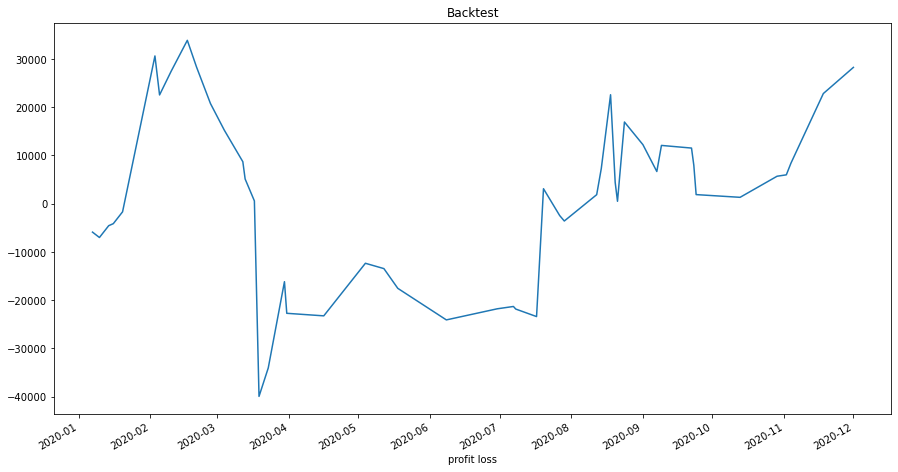

In [232]:
daily_profit_loss['損益'].cumsum()
daily_profit_loss['損益'].cumsum().plot(title='Backtest', figsize=(15, 8)).set(xlabel='profit loss')